## 时间滚动框架

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from sklearn.metrics import r2_score
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real

In [ ]:
models = {
    # 1. 简单线性回归
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {}
    },
    # 2. Huber回归
    "Huber Regression": {
        "model": HuberRegressor(),
        "param_grid": {}
    },
    # 3. Elastic Net（使用Huber损失）
    "Elastic Net (Huber)": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
        "search_cv": BayesSearchCV
    },
    # 更新Elastic Net 以使用贝叶斯优化
    "Elastic Net": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
        "search_cv": BayesSearchCV
    },
    # 5. 主成分回归 (PCR)
    "PCR": {
        "model": make_pipeline(PCA(), LinearRegression()),
        "param_grid": {
            'pca__n_components': np.arange(5, 30, dtype='int')
        }
    },
    # 6. 偏最小二乘法 (PLS)
    "PLS": {
        "model": PLSRegression(),
        "param_grid": {
            'n_components': [5, 10, 15, 20, 25]
        }
    },
    # 7. 广义线性模型 (GLM)
    "Generalized Linear Model": {
        "model": make_pipeline(PolynomialFeatures(), Lasso()),
        "param_grid": {
            'polynomialfeatures__degree': [2, 3],
            'lasso__alpha': [0.01, 0.05, 0.1, 0.5]
        }
    },
    # 8. 提升回归树
    "Boosted Regression Trees": {
        "model": GradientBoostingRegressor(),
        "param_grid": {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [1, 2, 3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.2, 0.3]
        }
    },
    # 9. 随机森林
    "Random Forests": {
        "model": RandomForestRegressor(),
        "param_grid": {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'max_features': ['sqrt', 'log2']
        }
    }
}

In [14]:
def time_rolling_cross_validation(models, start_year=2010, end_year=2017):
    results = {model_name: {"r2_scores": [], "params": [], "feature_counts": []} for model_name in models.keys()}

    for model_name, model_info in models.items():
        all_y_test = []
        all_y_pred = []

        for year in range(start_year, end_year + 1):
            train_data = pd.read_csv(f'dataset/2008-{year}train_data.csv')
            val_data = pd.read_csv(f'dataset/2008-{year}val_data.csv')
            test_data = pd.read_csv(f'dataset/2008-{year}test_data.csv')

            X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
            X_val, y_val = val_data.iloc[:, :-1], val_data.iloc[:, -1]
            X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

            X_combined = np.vstack((X_train, X_val))
            y_combined = np.concatenate((y_train, y_val))
            test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
            ps = PredefinedSplit(test_fold)

            del X_val, y_val, train_data, val_data, test_data
            gc.collect()

            model, param_grid = model_info["model"], model_info["param_grid"]
            search_cv = model_info.get("search_cv", GridSearchCV)

            grid_search = search_cv(model, param_grid, cv=ps)
            grid_search.fit(X_combined, y_combined)

            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)

            y_pred = best_model.predict(X_test).ravel()
            y_test = y_test.ravel()

            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)

            # 记录调整后的R²得分
            r2_in_sample = r2_score(y_train, best_model.predict(X_train))
            r2_out_of_sample = r2_score(y_test, y_pred)
            results[model_name]["r2_scores"].append((year, r2_in_sample, r2_out_of_sample))

            # 记录超参数
            results[model_name]["params"].append((year, grid_search.best_params_))

            # 记录特征数量（对于有特征选择的模型）
            feature_count = X_train.shape[1] if hasattr(best_model, 'n_features_') else None
            results[model_name]["feature_counts"].append((year, feature_count))

            del X_train, y_train, X_test, y_test, X_combined, y_combined
            gc.collect()

        # 计算自定义R²
        r2_custom = r2_score(all_y_test, all_y_pred)
        results[model_name]["r2_scores"].append(("Overall", r2_custom))

    return results

In [4]:
models_OLS = {
    # 1. 简单线性回归
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {}
    }
}

In [11]:
r2_scores_OLS = time_rolling_cross_validation(models_OLS, start_year=2010, end_year=2017)
for model_name, info in r2_scores_OLS.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

Linear Regression:
 R² Scores: [(2010, 0.6300591211645604, 0.4534336098309232), (2011, 0.6318095699589161, 0.3295995856120365), (2012, 0.625878540621579, 0.3489444261025022), (2013, 0.6254213935080511, 0.14851713339147254), (2014, 0.6201886660516325, 0.21924106991426484), (2015, 0.5677076633907587, 0.10345588966077945), (2016, 0.5113006630708957, 0.11410490991562572), (2017, 0.3719614690133969, 0.06400023242066877), ('Overall', 0.13283738382640686)]
 Parameters: [(2010, {}), (2011, {}), (2012, {}), (2013, {}), (2014, {}), (2015, {}), (2016, {}), (2017, {})]
 Feature Counts: [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]


In [12]:
models_HB = {
    # 2. Huber回归
    "Huber Regression": {
        "model": HuberRegressor(),
        "param_grid": {}
    }
}

In [13]:
r2_scores_HB = time_rolling_cross_validation(models_HB, start_year=2010, end_year=2017)
for model_name, info in r2_scores_HB.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

Huber Regression:
 R² Scores: [(2010, 0.5606230487089054, 0.551068338432908), (2011, 0.5723005233209372, 0.37929756278783044), (2012, 0.5739813233458881, 0.3440991319833526), (2013, 0.5717691862501031, 0.1346404581058699), (2014, 0.5671339769932767, 0.19527775319386764), (2015, 0.5130070887084908, 0.08726307774891418), (2016, 0.4563010277754489, 0.10382989837516843), (2017, 0.323262276527321, 0.05516093599362937), ('Overall', 0.12547004727192812)]
 Parameters: [(2010, {}), (2011, {}), (2012, {}), (2013, {}), (2014, {}), (2015, {}), (2016, {}), (2017, {})]
 Feature Counts: [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]


In [11]:
from sklearn.metrics import make_scorer

# 定义自定义的Huber损失函数
def huber_loss(y_true, y_pred, delta=1.0, sigma=1.0):
    error = (y_true - y_pred) / sigma
    abs_error = np.abs(error)
    squared_error = 0.5 * error**2
    linear_error = delta * abs_error - 0.5 * delta**2
    return np.where(abs_error <= delta, squared_error, linear_error).mean()

# 创建一个评分器，使用自定义的Huber损失函数
huber_scorer = make_scorer(huber_loss, greater_is_better=False)

In [16]:
models_ENHB = {
    # Elastic Net（使用Huber损失）
    "Elastic Net (Huber)": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0.01, 0.9),
            'l1_ratio': Real(0.01, 0.9)
        },
    "search_cv": lambda estimator, param_grid, **kwargs: BayesSearchCV(
            estimator, param_grid, scoring=huber_scorer, **kwargs  # 接受并传递所有额外的关键字参数
        )
    }
}

In [17]:
r2_scores_ENHB = time_rolling_cross_validation(models_ENHB, start_year=2010, end_year=2017)
for model_name, info in r2_scores_ENHB.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

Elastic Net (Huber):
 R² Scores: [(2010, 0.5234620823341616, 0.5416123931450998), (2011, 0.5508465151232746, 0.4046794546207969), (2012, 0.5646831956482967, 0.3485258514778996), (2013, 0.5687413537515942, 0.13988443300163045), (2014, 0.5358359078366394, 0.1941648451040271), (2015, 0.48571395485870017, 0.08559744812669456), (2016, 0.40333653931226754, 0.0946409210186997), (2017, 0.2856202846383261, 0.05033243919721364), ('Overall', 0.12290251267988306)]
 Parameters: [(2010, OrderedDict([('alpha', 0.3578325248591418), ('l1_ratio', 0.01)])), (2011, OrderedDict([('alpha', 0.24073740744577526), ('l1_ratio', 0.1425047589270789)])), (2012, OrderedDict([('alpha', 0.20783826549178128), ('l1_ratio', 0.04751545659256995)])), (2013, OrderedDict([('alpha', 0.18615031581325325), ('l1_ratio', 0.1556424986869455)])), (2014, OrderedDict([('alpha', 0.29403349578096755), ('l1_ratio', 0.12016003499532595)])), (2015, OrderedDict([('alpha', 0.31783129134548427), ('l1_ratio', 0.09195385426755069)])), (2016, 

In [5]:
models_ENB = {
    # 更新Elastic Net 以使用贝叶斯优化
    "Elastic Net": {
        "model": ElasticNet(),
        "param_grid": {
            'alpha': Real(0.001, 0.9),
            'l1_ratio': Real(0.001, 0.9)
        },
        "search_cv": BayesSearchCV
    }
}

In [6]:
r2_scores_ENB = time_rolling_cross_validation(models_ENB, start_year=2010, end_year=2017)
for model_name, info in r2_scores_ENB.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\python\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective h

Elastic Net:
 R² Scores: [(2010, 0.5722583957728818, 0.5620275704981863), (2011, 0.5976381712202636, 0.40086308772012547), (2012, 0.6041110187892019, 0.36033635288841803), (2013, 0.6133489546007248, 0.14644670811609894), (2014, 0.6159818530222272, 0.220313154779879), (2015, 0.5666587344867919, 0.10255980446582535), (2016, 0.5104156389882533, 0.1145642607847952), (2017, 0.371270055131504, 0.06514515988583136), ('Overall', 0.13849155980765382)]
 Parameters: [(2010, OrderedDict([('alpha', 0.1633388454940767), ('l1_ratio', 0.08336032275963917)])), (2011, OrderedDict([('alpha', 0.07148702638845049), ('l1_ratio', 0.47260123905408546)])), (2012, OrderedDict([('alpha', 0.058442668516200655), ('l1_ratio', 0.30440456430982155)])), (2013, OrderedDict([('alpha', 0.03074461426931418), ('l1_ratio', 0.6195418351616694)])), (2014, OrderedDict([('alpha', 0.027554998108516277), ('l1_ratio', 0.01)])), (2015, OrderedDict([('alpha', 0.01), ('l1_ratio', 0.01)])), (2016, OrderedDict([('alpha', 0.01), ('l1_ra

In [7]:
models_PCR = {
    # 5. 主成分回归 (PCR)
    "PCR": {
        "model": make_pipeline(PCA(), LinearRegression()),
        "param_grid": {
            'pca__n_components': np.arange(5, 30, dtype='int')
        }
    }
}

In [8]:
r2_scores_PCR = time_rolling_cross_validation(models_PCR, start_year=2010, end_year=2017)
for model_name, info in r2_scores_PCR.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

PCR:
 R² Scores: [(2010, 0.5849126308085123, 0.5041998109737555), (2011, 0.5944911546268292, 0.363927942768147), (2012, 0.5992659431758813, 0.35524519579421576), (2013, 0.6064940848398734, 0.1462816560890965), (2014, 0.6187096666473029, 0.21464451790434702), (2015, 0.565768083808464, 0.1011370858017413), (2016, 0.5087599848112097, 0.1137395798126678), (2017, 0.36940587297576943, 0.06431063463933662), ('Overall', 0.13451392364599624)]
 Parameters: [(2010, {'pca__n_components': 26}), (2011, {'pca__n_components': 26}), (2012, {'pca__n_components': 25}), (2013, {'pca__n_components': 27}), (2014, {'pca__n_components': 29}), (2015, {'pca__n_components': 29}), (2016, {'pca__n_components': 29}), (2017, {'pca__n_components': 29})]
 Feature Counts: [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]


In [9]:
models_PLS = {
    # 6. 偏最小二乘法 (PLS)
    "PLS": {
        "model": PLSRegression(),
        "param_grid": {
            'n_components': [5, 10, 15, 20, 25]
        }
    }
}

In [10]:
r2_scores_PLS = time_rolling_cross_validation(models_PLS, start_year=2010, end_year=2017)
for model_name, info in r2_scores_PLS.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

PLS:
 R² Scores: [(2010, 0.6154879142411138, 0.46926797215501315), (2011, 0.6215901111118414, 0.34403981002035), (2012, 0.6167480098078681, 0.35706037801604684), (2013, 0.6247452750878888, 0.1485246624243869), (2014, 0.6201265662368486, 0.2195818041903861), (2015, 0.5675698393473272, 0.10278888989396762), (2016, 0.5112939900163487, 0.11403710989677351), (2017, 0.37201326368404064, 0.06396449962121553), ('Overall', 0.13392236606949814)]
 Parameters: [(2010, {'n_components': 5}), (2011, {'n_components': 5}), (2012, {'n_components': 5}), (2013, {'n_components': 10}), (2014, {'n_components': 25}), (2015, {'n_components': 20}), (2016, {'n_components': 20}), (2017, {'n_components': 25})]
 Feature Counts: [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]


In [11]:
models_GLM = {
    # 7. 广义线性模型 (GLM)
    "Generalized Linear Model": {
        "model": make_pipeline(PolynomialFeatures(), Lasso()),
        "param_grid": {
            'polynomialfeatures__degree': [2, 3],
            'lasso__alpha': [0.001, 0.003, 0.007, 0.01, 0.05]
        }
    }
}

In [12]:
r2_scores_GLM = time_rolling_cross_validation(models_GLM, start_year=2010, end_year=2017)
for model_name, info in r2_scores_GLM.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

Generalized Linear Model:
 R² Scores: [(2010, 0.7083485453153846, 0.7070202315772175), (2011, 0.8222126994237742, 0.5439398265874342), (2012, 0.8045493128496504, 0.5179570052512995), (2013, 0.8025787190632071, 0.2394248234380163), (2014, 0.7943060305486613, 0.3726390083558948), (2015, 0.7420258547836542, 0.19814675606454257), (2016, 0.6844226710262848, 0.203803480014899), (2017, 0.5226458941712244, 0.1337249729416531), ('Overall', 0.23247391059830913)]
 Parameters: [(2010, {'lasso__alpha': 0.05, 'polynomialfeatures__degree': 3}), (2011, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}), (2012, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}), (2013, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}), (2014, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}), (2015, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}), (2016, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3}), (2017, {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 3})]
 Feature 

In [13]:
models_GB = {
    # 8. 提升回归树
    "Boosted Regression Trees": {
        "model": GradientBoostingRegressor(),
        "param_grid": {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [1, 2, 3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.2, 0.3]
        }
    }
}

In [ ]:
r2_scores_GB = time_rolling_cross_validation(models_GB, start_year=2010, end_year=2017)
for model_name, info in r2_scores_GB.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

In [ ]:
models_RF = {
    # 9. 随机森林
    "Random Forests": {
        "model": RandomForestRegressor(),
        "param_grid": {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'max_features': ['sqrt', 'log2']
        }
    }
}

In [ ]:
r2_scores_RF = time_rolling_cross_validation(models_RF, start_year=2010, end_year=2017)
for model_name, info in r2_scores_RF.items():
    print(f"{model_name}:")
    print(" R² Scores:", info["r2_scores"])
    print(" Parameters:", info["params"])
    print(" Feature Counts:", info["feature_counts"])

## 结果保存及处理

In [20]:
import pandas as pd

class ModelComparisonData:
    def __init__(self):
        # 初始化用于存储数据的字典
        self.data = {
            "Linear Regression": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Huber Regression": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Elastic Net (Huber)": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Elastic Net": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "PCR": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "PLS": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Generalized Linear Model": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Random Forests": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []},
            "Boosted Regression Trees": {"R2_in": [], "R2_out": [], "R2_overall": None, "Feature_Count": []}
        }
    def add_model_data(self, model_name, r2_scores, feature_counts):
        # 添加模型数据
        for data in r2_scores:
            if data[0] == 'Overall':
                self.data[model_name]["R2_overall"] = data[1]
            else:
                year, r2_in, r2_out = data
                self.data[model_name]["R2_in"].append((year, r2_in))
                self.data[model_name]["R2_out"].append((year, r2_out))
    
        for year, count in feature_counts:
            self.data[model_name]["Feature_Count"].append((year, count))

# 实例化对象
model_data = ModelComparisonData()

# 添加线性回归数据
model_data.add_model_data(
    "Linear Regression",
    [(2010, 0.6300591211645604, 0.4534336098309232), (2011, 0.6318095699589161, 0.3295995856120365), (2012, 0.625878540621579, 0.3489444261025022), (2013, 0.6254213935080511, 0.14851713339147254), (2014, 0.6201886660516325, 0.21924106991426484), (2015, 0.5677076633907587, 0.10345588966077945), (2016, 0.5113006630708957, 0.11410490991562572), (2017, 0.3719614690133969, 0.06400023242066877), ('Overall', 0.13283738382640686)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Huber回归数据
model_data.add_model_data(
    "Huber Regression",
    [(2010, 0.5606230487089054, 0.551068338432908), (2011, 0.5723005233209372, 0.37929756278783044), (2012, 0.5739813233458881, 0.3440991319833526), (2013, 0.5717691862501031, 0.1346404581058699), (2014, 0.5671339769932767, 0.19527775319386764), (2015, 0.5130070887084908, 0.08726307774891418), (2016, 0.4563010277754489, 0.10382989837516843), (2017, 0.323262276527321, 0.05516093599362937), ('Overall', 0.12547004727192812)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Elastic Net (Huber)数据
model_data.add_model_data(
    "Elastic Net (Huber)",
    [(2010, 0.5234620823341616, 0.5416123931450998), (2011, 0.5508465151232746, 0.4046794546207969), (2012, 0.5646831956482967, 0.3485258514778996), (2013, 0.5687413537515942, 0.13988443300163045), (2014, 0.5358359078366394, 0.1941648451040271), (2015, 0.48571395485870017, 0.08559744812669456), (2016, 0.40333653931226754, 0.0946409210186997), (2017, 0.2856202846383261, 0.05033243919721364), ('Overall', 0.12290251267988306)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Elastic Net数据
model_data.add_model_data(
    "Elastic Net",
    [(2010, 0.5722583957728818, 0.5620275704981863), (2011, 0.5976381712202636, 0.40086308772012547), (2012, 0.6041110187892019, 0.36033635288841803), (2013, 0.6133489546007248, 0.14644670811609894), (2014, 0.6159818530222272, 0.220313154779879), (2015, 0.5666587344867919, 0.10255980446582535), (2016, 0.5104156389882533, 0.1145642607847952), (2017, 0.371270055131504, 0.06514515988583136), ('Overall', 0.13849155980765382)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
    
)


# 添加PCR数据
model_data.add_model_data(
    "PCR",
    [(2010, 0.5849126308085123, 0.5041998109737555), (2011, 0.5944911546268292, 0.363927942768147), (2012, 0.5992659431758813, 0.35524519579421576), (2013, 0.6064940848398734, 0.1462816560890965), (2014, 0.6187096666473029, 0.21464451790434702), (2015, 0.565768083808464, 0.1011370858017413), (2016, 0.5087599848112097, 0.1137395798126678), (2017, 0.36940587297576943, 0.06431063463933662), ('Overall', 0.13451392364599624)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加PLS模型数据
model_data.add_model_data(
    "PLS",
    [(2010, 0.6154879142411138, 0.46926797215501315), (2011, 0.6215901111118414, 0.34403981002035), (2012, 0.6167480098078681, 0.35706037801604684), (2013, 0.6247452750878888, 0.1485246624243869), (2014, 0.6201265662368486, 0.2195818041903861), (2015, 0.5675698393473272, 0.10278888989396762), (2016, 0.5112939900163487, 0.11403710989677351), (2017, 0.37201326368404064, 0.06396449962121553), ('Overall', 0.13392236606949814)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Generalized Linear Model数据
model_data.add_model_data(
    "Generalized Linear Model",
    [(2010, 0.7083485453153846, 0.7070202315772175), (2011, 0.8222126994237742, 0.5439398265874342), (2012, 0.8045493128496504, 0.5179570052512995), (2013, 0.8025787190632071, 0.2394248234380163), (2014, 0.7943060305486613, 0.3726390083558948), (2015, 0.7420258547836542, 0.19814675606454257), (2016, 0.6844226710262848, 0.203803480014899), (2017, 0.5226458941712244, 0.1337249729416531), ('Overall', 0.23247391059830913)],
    [(2010, None), (2011, None), (2012, None), (2013, None), (2014, None), (2015, None), (2016, None), (2017, None)]
)

# 添加Random Forests数据
model_data.add_model_data(
    "Random Forests",
    [(2010, 1.0, 0.756604015827179), (2011, 1.0, 0.6721858978271484), (2012, 1.0, 0.6124632358551025), (2013, 1.0, 0.327730655670166), (2014, 1.0, 0.5459038019180298), (2015, 1.0, 0.39652198553085327), (2016, 1.0, 0.44025933742523193), (2017, 1.0, 0.3507566452026367), ('Overall', 0.4204270828950054)],
    [(2010, 39), (2011, 39), (2012, 39), (2013, 39), (2014, 39), (2015, 39), (2016, 39), (2017, 39)]
)

# 添加Boosted Regression Trees数据
model_data.add_model_data(
    "Boosted Regression Trees",
    [(2010, 1.0, 0.8286232695775332), (2011, 1.0, 0.7196253818275358), (2012, 1.0, 0.6570038462537695), (2013, 1.0, 0.38791923876046963), (2014, 1.0, 0.6506053296191967), (2015, 1.0, 0.49595732761557976), (2016, 1.0, 0.5831735228495675), (2017, 1.0, 0.33694900151391804), ('Overall', 0.4778653548926247)],
    [(2010, 39), (2011, 39), (2012, 39), (2013, 39), (2014, 39), (2015, 39), (2016, 39), (2017, 39)]
)


def create_dataframe(data_list, columns):
    """将数据列表转换为pandas DataFrame"""
    return pd.DataFrame(data_list, columns=columns)

# 创建Excel写入器
excel_writer = pd.ExcelWriter("model_comparison.xlsx", engine='openpyxl')

# 遍历每个模型，创建DataFrame并写入对应的工作表
for model_name, model_data in model_data.data.items():
    # 创建样本内R²的DataFrame
    df_in = create_dataframe(model_data["R2_in"], columns=["Year", "R2_in"])
    df_in.to_excel(excel_writer, sheet_name=f"{model_name} R2_in", index=False)

    # 创建样本外R²的DataFrame
    df_out = create_dataframe(model_data["R2_out"], columns=["Year", "R2_out"])
    df_out.to_excel(excel_writer, sheet_name=f"{model_name} R2_out", index=False)

    # 创建总体R²的DataFrame
    df_overall = pd.DataFrame({"R2_overall": [model_data["R2_overall"]]})
    df_overall.to_excel(excel_writer, sheet_name=f"{model_name} R2_overall", index=False)

    # 创建特征数的DataFrame
    df_features = create_dataframe(model_data["Feature_Count"], columns=["Year", "Feature_Count"])
    df_features.to_excel(excel_writer, sheet_name=f"{model_name} Feature_Count", index=False)


# 保存并关闭Excel文件
excel_writer.close()

# 提示完成
print("数据已成功写入Excel文件 'model_comparison.xlsx'")


数据已成功写入Excel文件 'model_comparison.xlsx'


D:\python\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


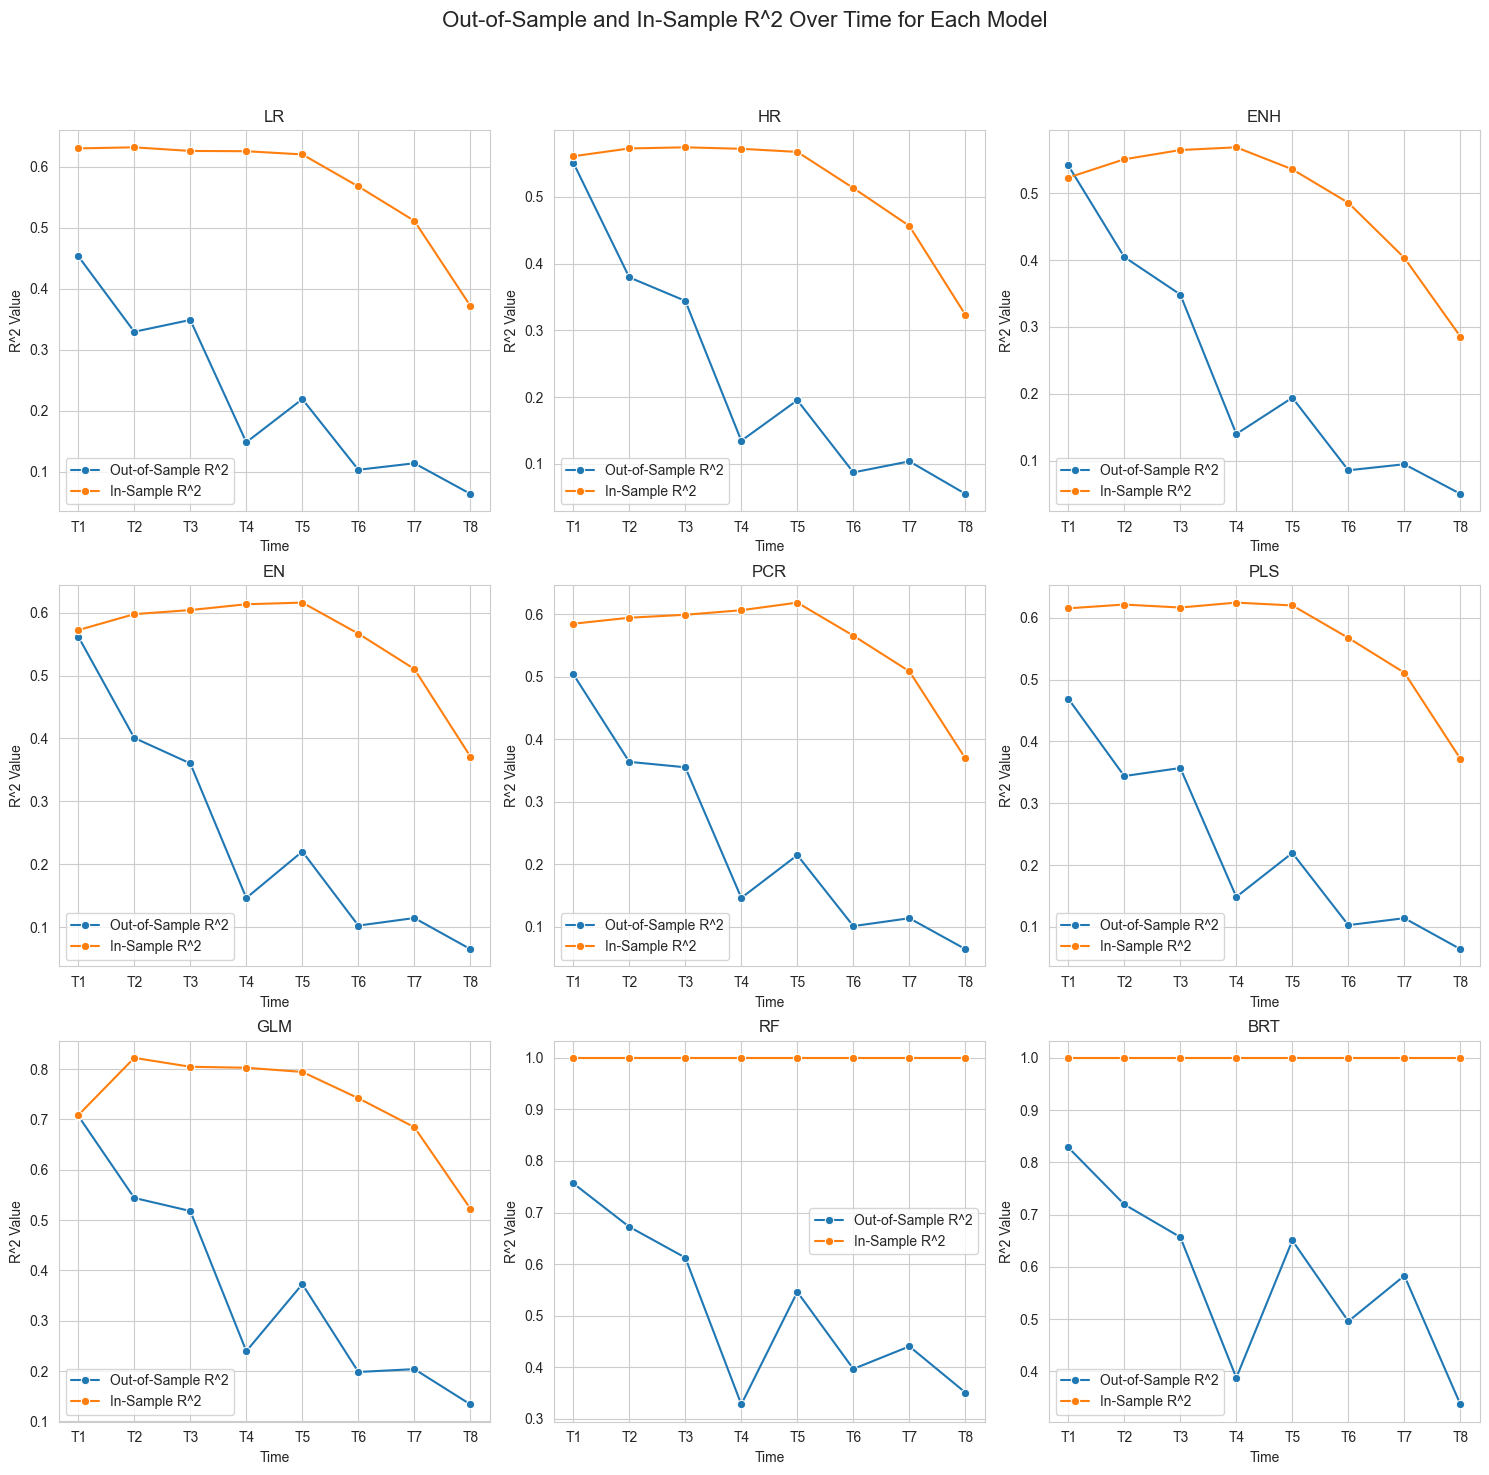

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = './output.xlsx'

outR2_df = pd.read_excel(file_path, 'outR^2')
oosR2_df = pd.read_excel(file_path, 'R^2oos')
inR2_df = pd.read_excel(file_path, 'inR^2')

sns.set_style("whitegrid")

# Function to plot 3x3 line charts for outR^2 and inR^2 together for each model
def plot_3x3_line_charts(out_df, in_df):
    # Number of models
    num_models = len(out_df.columns) - 1 


    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    fig.suptitle('Out-of-Sample and In-Sample R^2 Over Time for Each Model', fontsize=16)

    axes = axes.flatten()

    for i, model in enumerate(out_df.columns[1:]):
        sns.lineplot(data=out_df, x='Unnamed: 0', y=model, ax=axes[i], marker='o', label='Out-of-Sample R^2')
        sns.lineplot(data=in_df, x='Unnamed: 0', y=model, ax=axes[i], marker='o', label='In-Sample R^2')
        axes[i].set_title(model)
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('R^2 Value')
        axes[i].legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_3x3_line_charts(outR2_df, inR2_df)


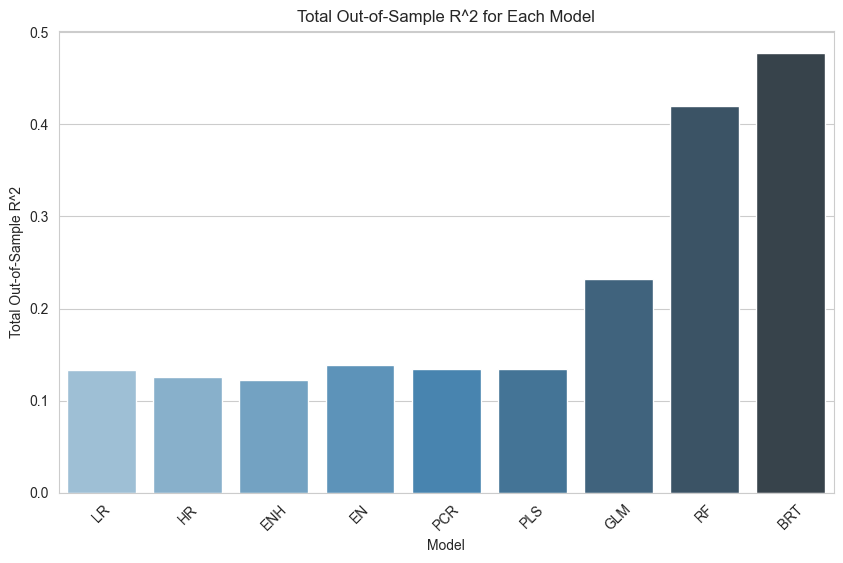

In [22]:
# Task 2: Plotting the histogram for R^2oos with the same color for each bar
plt.figure(figsize=(10, 6))
sns.barplot(data=oosR2_df, palette="Blues_d")
plt.title('Total Out-of-Sample R^2 for Each Model')
plt.xlabel('Model')
plt.ylabel('Total Out-of-Sample R^2')
plt.xticks(rotation=45)
plt.show()


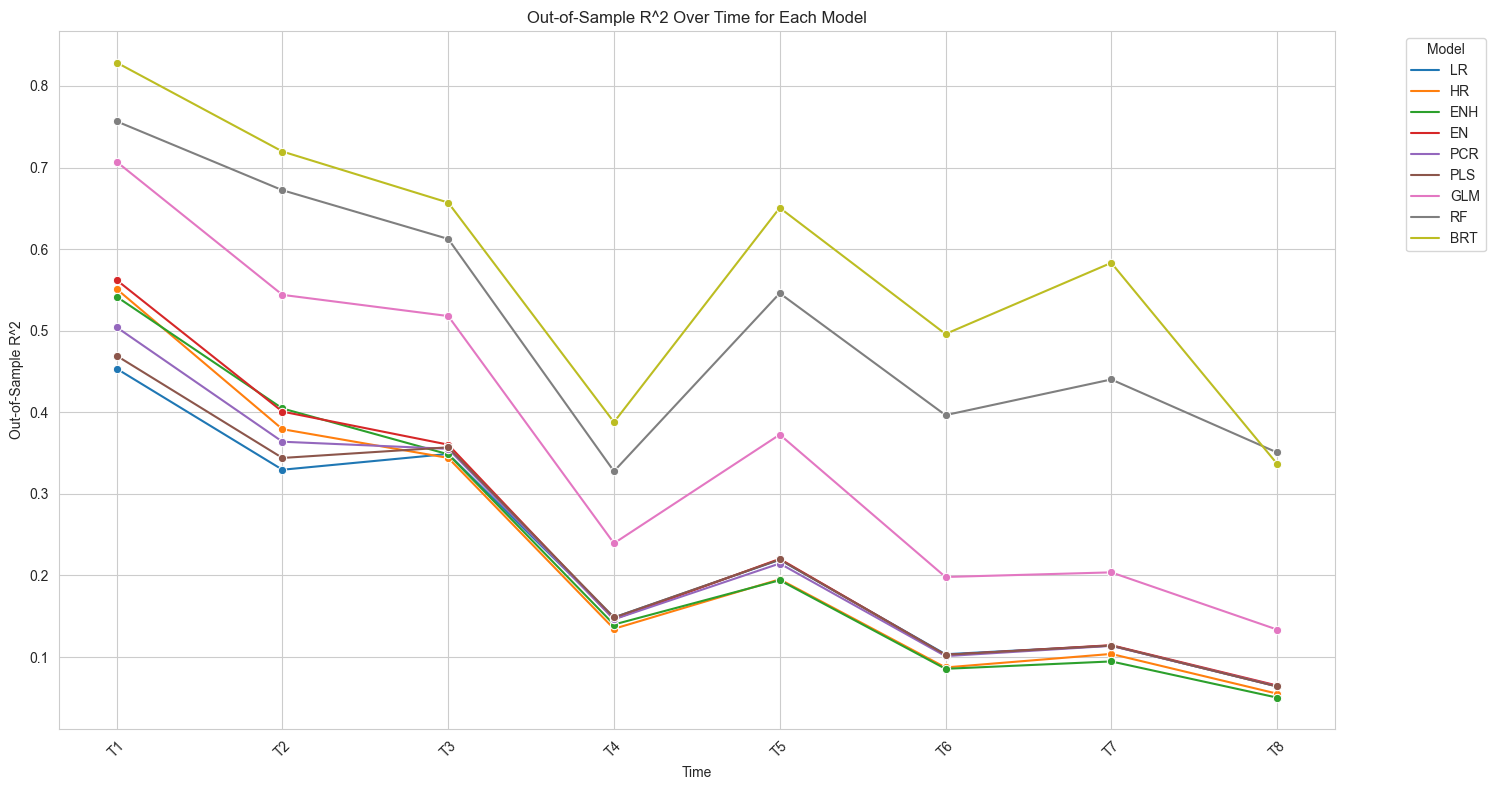

In [23]:
# Task 3: Preparing data for line plot of Out-of-Sample R^2
outR2_line_df = outR2_df.melt(id_vars=['Unnamed: 0'], var_name='Model', value_name='R^2')
outR2_line_df = outR2_line_df.rename(columns={'Unnamed: 0': 'Time'})


plt.figure(figsize=(15, 8))
sns.lineplot(data=outR2_line_df, x='Time', y='R^2', hue='Model', marker='o')
plt.title('Out-of-Sample R^2 Over Time for Each Model')
plt.xlabel('Time')
plt.ylabel('Out-of-Sample R^2')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
